In [1]:
%matplotlib inline

import numpy as np
from scipy.sparse import coo_matrix
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# Import user-item rating dataframe

ratings_red = pd.read_json('ratings_vreduced.json')

In [3]:
# Determine how many user-item pairs are filled

n_users = len(ratings_red.user.unique())
n_games = len(ratings_red.gameid.unique())
sparsity = float(len(ratings_red))/(n_users*n_games)*100
print str(sparsity)+'% of user-item ratings are filled.'

15.3119521338% of user-item ratings are filled.


In [4]:
# Convert user names and game IDs to matrix indices

userdict = {}
for i, user in enumerate(ratings_red.user.unique()):
    userdict[user] = i
    
gamedict = {}
for i, game in enumerate(ratings_red.gameid.unique()):
    gamedict[game] = i
    
ratings_red['user'] = ratings_red['user'].map(userdict.get)
ratings_red['gameid'] = ratings_red['gameid'].map(gamedict.get)

In [5]:
# Split data in testing and training sets

X = ratings_red[['gameid','user']]
y = ratings_red['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=29, stratify=X['user'])

In [6]:
# Build a user-item score matrix from training data

train = coo_matrix((y_train, (X_train['user'],X_train['gameid'])))
train = train.todense()

In [7]:
def fillavg(ratings):
    """This function fills the empty items in a rating matrix with the
    item average score"""
    rate = pd.DataFrame(ratings.copy())
    rate[rate==0] = np.nan
    rate = rate.fillna(rate.mean())
    return rate.as_matrix()

In [8]:
# Determine a 'baseline' score predition where all missing scores are predicted by the item's average score

pred_baseline = fillavg(train)

In [9]:
def rmse(X, y, prediction):
    """This function calculates mean squared-error of the prediction.
    Inputs are a dataframe of indices, a dataframe of scores, and the
    matrix of predicted values"""
    y_pred = []
    for row in X.itertuples():
        y_pred.append(prediction[row[2],row[1]])
    return np.sqrt(mean_squared_error(y, y_pred))

In [10]:
# Calculate RMSE for baseline model

print 'RMSE: ' + str(rmse(X_test,y_test,pred_baseline))

RMSE: 1.3688170609103507


In [11]:
def uu_similarity(ratings):
    """This function calculates a user-user similarity matrix using
    a cosine-distance between each user-user pair's ratings"""
    ratings2 = ratings + 1e-10
    similarity = ratings2.dot(ratings2.T)
    norms = np.matrix(np.sqrt(similarity.diagonal()))
    return similarity/norms/norms.T

In [12]:
def uu_predict(ratings, similarity):
    """This function predicts user-user ratings by averaging all
    ratings for a game weighted by user-user similarity"""
    similarity2 = similarity.copy()
    np.fill_diagonal(similarity2, 0)
    predictions = np.divide(similarity2.dot(ratings),np.abs(similarity2).dot(ratings!= 0))
    return predictions

In [13]:
sim = uu_similarity(train)

In [14]:
pred = uu_predict(train, sim)

In [15]:
print 'RMSE: ' + str(rmse(X_test,y_test,pred))

RMSE: 1.3656142856275606


In [16]:
def uu_predict_topk(ratings, similarity, k):
    """This function predicts user-user ratings by averaging ratings
    for a game weighted by user-user similarity for only the k most
    similar users"""
    similarity2 = similarity.copy()
    np.fill_diagonal(similarity2, 0)
    nanfill = np.divide(similarity2.dot(ratings),np.abs(similarity2).dot(ratings!= 0))
    filt = similarity2.argsort()[:,:len(similarity2)-k]
    for index, row in enumerate(filt):
        similarity2[index,row]=0
    predictions = np.divide(similarity2.dot(ratings),np.abs(similarity2).dot(ratings != 0))
    predictions = pd.DataFrame(predictions).fillna(pd.DataFrame(nanfill))
    return predictions.as_matrix()

In [25]:
# calculate rmse for a variety of k using kNN similarity

rmse_test = []
ks = [10,50,100,150,200,250,300,350,400,450,500]
for k in ks:
    pred_topk = uu_predict_topk(train, sim.copy(), k)
    rmse_test.append(rmse(X_test,y_test,pred_topk))

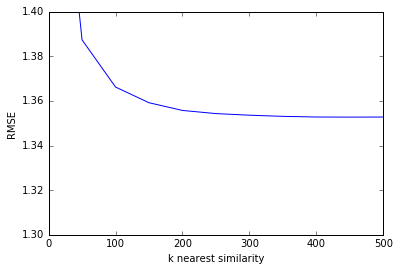

In [29]:
plt.plot(ks, rmse_test)
plt.ylim([1.3,1.4])
plt.xlim([0,500])
plt.xlabel('k nearest similarity')
plt.ylabel('RMSE')
plt.show()

In [31]:
def unbias(ratings):
    """This function subtracts out each user's mean rating from their individual ratings"""
    rate = pd.DataFrame(ratings.copy().T)
    rate[rate == 0] = np.nan
    means = rate.mean()
    rate = (rate-means).fillna(0)
    return rate.as_matrix().T, means

In [32]:
def rebias(ratings, means):
    """This function adds back in each user's average rating to their predicted ratings"""
    rate = pd.DataFrame(ratings.copy().T)
    rate = rate+means
    rate[rate > 10] = 10 # Correct for ratings greater than 10 (rating scale goes from 1-10)
    rate[rate < 1] = 1 # Correct for ratings less than 1 (rating scale goes from 1-10)
    return rate.as_matrix().T

In [33]:
train_unbias, means = unbias(train)

In [34]:
sim_unbias = uu_similarity(train_unbias)

In [35]:
pred_unbias = uu_predict(train_unbias, sim_unbias)
pred_unbias = rebias(pred_unbias, means)

In [36]:
rmse(X_test,y_test,pred_unbias)

1.1785943199711686

In [37]:
# calculate rmse for a variety of k using kNN similarity with rating bias subtracted

rmse_test_unbias = []
ks = [10,50,100,150,200,250,300,350,400,450,500]
for k in ks:
    pred_unbias_topk = uu_predict_topk(train_unbias, sim_unbias, k)
    pred_unbias_topk = rebias(pred_unbias_topk, means)
    rmse_test_unbias.append(rmse(X_test,y_test,pred_unbias_topk))

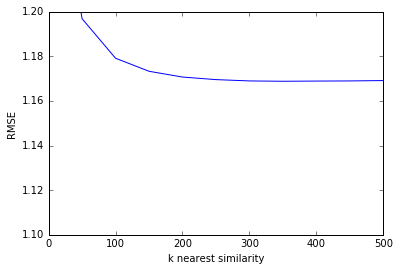

In [43]:
plt.plot(ks, rmse_test_unbias)
plt.ylim([1.1,1.2])
plt.xlim([0,500])
plt.xlabel('k nearest similarity')
plt.ylabel('RMSE')
plt.show()

## Testing on my own account

In [71]:
# Import my own account's ratings

my_ratings = pd.read_json('my_ratings.json')
my_ratings2 = my_ratings.copy()
my_ratings2['gameid'] = my_ratings2['gameid'].map(gamedict.get)
my_ratings2 = my_ratings2.dropna()

In [72]:
# Convert my ratings into a ratings matrix

my_ratings_mat = coo_matrix((my_ratings2.score, (np.zeros_like(my_ratings2.gameid),my_ratings2.gameid)),
                            shape = [1, n_games]).todense()

In [73]:
# Convert full ratings into rating matrix

full_ratings = coo_matrix((y, (X['user'],X['gameid']))).todense()

In [74]:
my_ratings_unbias, my_mean = unbias(my_ratings_mat)
full_ratings_unbias, full_means = unbias(full_ratings)

In [75]:
def su_similarity(u_ratings, ratings):
    """This function calculates a single user's similarity vector using
    a cosine-distance between that user's ratings and every user's ratings
    in the full matrix"""
    norms = np.sqrt(full_ratings.dot(full_ratings.T).diagonal())
    denom = norms * np.linalg.norm(my_ratings)
    return np.divide(u_ratings.dot(full_ratings.T), denom)

In [76]:
my_sim = su_similarity(my_ratings_unbias, full_ratings_unbias)

In [77]:
def su_predict_topk(ratings, similarity, k):
    """This function predicts a single user's ratings by averaging ratings
    for a game weighted by user-user similarity for only the k most
    similar users"""
    similarity2 = similarity.copy()
    filt = similarity2.argsort()[:,:len(similarity2)-k]
    for index, row in enumerate(filt):
        similarity2[index,row]=0
    predictions = np.divide(similarity2.dot(ratings),np.abs(similarity2).dot(ratings != 0))
    return predictions

In [78]:
# Predict my ratings based on 350 most similar users

my_pred = su_predict_topk(full_ratings_unbias, my_sim, 350)
my_pred = rebias(my_pred, my_mean)
my_pred = pd.DataFrame(my_pred).transpose()
my_pred.columns = ['predicted_score']

In [66]:
# Import game database file in order to parse game IDs back to the game names

game_df = pd.read_json('bgg_database.json')['name']
game_df.index.name = 'gameid'
game_df = game_df.reset_index()

In [79]:
# Replace game IDs with game names

recommendations = pd.DataFrame.from_dict(gamedict, orient = 'index').reset_index()
recommendations.columns = ['gameid','index']
recommendations = recommendations.set_index('index').sort_index()
del recommendations.index.name
recommendations = recommendations.join(my_pred)
recommendations = recommendations.merge(game_df, how = 'left', left_on = 'gameid', right_on = 'gameid')

In [82]:
# Display my top 20 predicted games filtering out games that I have already rated

owned_filter = recommendations.gameid.isin(my_ratings.gameid)
recommendations[~owned_filter].sort_values('predicted_score', ascending = False).head(20)

,gameid,predicted_score,name
2293,38718,10.000000,Normandy '44
941,17651,10.000000,Under the Lily Banners
81,124839,10.000000,Hoplomachus: The Lost Cities
297,139131,10.000000,Hoplomachus: Rise of Rome
319,14083,10.000000,Fire in the Sky: The Great Pacific War 1941-1945
928,1758,10.000000,Advanced Heroquest
683,162009,10.000000,The U.S. Civil War
2708,67600,10.000000,D-Day at Tarawa
2145,3408,10.000000,This Accursed Civil War
1109,18746,9.806325,Gustav Adolf the Great: With God and Victoriou...
